# AWS-LSTM for Audio-Language Model with Fast.ai
by @ste, @aamir7117 ,@zachcaceres


### TODO:
- full data set
- pretrained=False
- unfreeze latter layers
- true validation holdout (by speaker)
- augmentation
- make spectrogram a square

### IMPORTANT!!!
# ***We forgot to normalize the spectrogram input!!!! ***

## Data

In [1]:
import glob
from fastai.text import * 
from fastai.vision import *
from pathlib import Path
import pandas as pd
import torchaudio
from IPython.display import Audio
from torchaudio import transforms

## Timit phonemes dataaset
[dataset](https://github.com/philipperemy/timit)

In [2]:
timit_dir = Path('/home/ste/.fastai/data/timit')

In [3]:
(timit_dir/'TRAIN/DR1/MDPK0/').ls()

[PosixPath('/home/ste/.fastai/data/timit/TRAIN/DR1/MDPK0/SI1053.WRD'),
 PosixPath('/home/ste/.fastai/data/timit/TRAIN/DR1/MDPK0/SA1.PHN'),
 PosixPath('/home/ste/.fastai/data/timit/TRAIN/DR1/MDPK0/SX243.WAV'),
 PosixPath('/home/ste/.fastai/data/timit/TRAIN/DR1/MDPK0/SX423.WAV'),
 PosixPath('/home/ste/.fastai/data/timit/TRAIN/DR1/MDPK0/SX423.WRD'),
 PosixPath('/home/ste/.fastai/data/timit/TRAIN/DR1/MDPK0/SX333.PHN'),
 PosixPath('/home/ste/.fastai/data/timit/TRAIN/DR1/MDPK0/SI1683.TXT'),
 PosixPath('/home/ste/.fastai/data/timit/TRAIN/DR1/MDPK0/SA2.PHN'),
 PosixPath('/home/ste/.fastai/data/timit/TRAIN/DR1/MDPK0/SI1053.WAV'),
 PosixPath('/home/ste/.fastai/data/timit/TRAIN/DR1/MDPK0/SA1.WRD'),
 PosixPath('/home/ste/.fastai/data/timit/TRAIN/DR1/MDPK0/SX63.WRD'),
 PosixPath('/home/ste/.fastai/data/timit/TRAIN/DR1/MDPK0/SI552.WAV'),
 PosixPath('/home/ste/.fastai/data/timit/TRAIN/DR1/MDPK0/SX63.TXT'),
 PosixPath('/home/ste/.fastai/data/timit/TRAIN/DR1/MDPK0/SX333.WRD'),
 PosixPath('/home/ste/.fa

In [4]:
similar_and_sil = {
    'ao': 'aa',
    'hv': 'hh',
    'ix': 'ih',
    'el': 'l',
    'em': 'm',
    'en': 'n',
    'nx': 'n',
    'eng': 'ng',
    'ux': 'uw',
    'pcl': 'sil',
    'tcl': 'sil',
    'kcl': 'sil',
    'bcl': 'sil',
    'dcl': 'sil',
    'gcl': 'sil',
    'h#':  'sil',
    'pau': 'sil',
    'epi': 'sil'
}

In [5]:
sorted((timit_dir/'TRAIN/DR1/MDPK0/').ls())
phn, txt, wav = sorted((timit_dir/'TRAIN/DR1/MDPK0/').ls())[:3]
phn, txt

(PosixPath('/home/ste/.fastai/data/timit/TRAIN/DR1/MDPK0/SA1.PHN'),
 PosixPath('/home/ste/.fastai/data/timit/TRAIN/DR1/MDPK0/SA1.TXT'))

In [6]:
sig,sr = torchaudio.load(str(timit_dir/'TRAIN/DR1/MDPK0/SA1.WAV'))
Audio(data=sig, rate=sr)

In [7]:
Audio(data=sig[-1][11950:15665], rate=sr)

## Dataframe

In [8]:
def process_phn_file(p_file, sig, sr, delimiter=' '):
    df = pd.read_csv(p_file, delimiter=delimiter, header=None)
    df.columns = ['Start', 'End', 'Phn']
    df['Sample'] = df.apply(lambda x : sig[-1][x['Start']: x['End']], axis=1)
    return df

In [9]:
phns = []
final = pd.DataFrame()

for phn_file in glob.glob(str(timit_dir/'**/*.PHN'), recursive=True)[:24122]:
    sig,sr = torchaudio.load(str(phn_file.replace('PHN', 'WAV')))
    df = process_phn_file(phn_file, sig, sr, delimiter=' ')
    df['Source'] = phn_file
    final = final.append(df)

In [10]:
Audio(sig[-1][0:23080], rate=16000)

In [11]:
t = df.Sample[0]
t[None,:].shape
t = t[None,:]

In [12]:
transforms.MelSpectrogram(sr=16000)(t)

tensor([[[0.0000e+00, 2.2830e-06, 1.2292e-05,  ..., 6.1370e-07,
          2.5100e-06, 1.0183e-06],
         [0.0000e+00, 1.4187e-06, 7.6386e-06,  ..., 5.3597e-07,
          2.0883e-06, 7.4360e-07],
         [0.0000e+00, 4.6537e-07, 2.5057e-06,  ..., 8.3716e-06,
          4.3505e-06, 3.5764e-06],
         ...,
         [0.0000e+00, 2.1236e-07, 1.1434e-06,  ..., 5.1672e-06,
          4.8090e-06, 1.2439e-05],
         [0.0000e+00, 1.0892e-06, 5.8645e-06,  ..., 4.6738e-05,
          6.2746e-05, 6.5176e-05],
         [0.0000e+00, 9.3187e-07, 5.0174e-06,  ..., 3.0448e-04,
          2.0053e-04, 2.5253e-04]]])

In [13]:
df.head()

,Start,End,Phn,Sample,Source
0,0,2680,h#,"[tensor(0.0001), tensor(0.), tensor(3.0518e-05...",/home/ste/.fastai/data/timit/TEST/DR1/FJEM0/SX...
1,2680,4386,k,"[tensor(0.0013), tensor(0.0015), tensor(0.0005...",/home/ste/.fastai/data/timit/TEST/DR1/FJEM0/SX...
2,4386,4887,l,"[tensor(-0.0048), tensor(-0.0042), tensor(-0.0...",/home/ste/.fastai/data/timit/TEST/DR1/FJEM0/SX...
3,4887,6581,ih,"[tensor(0.0738), tensor(0.0495), tensor(0.0255...",/home/ste/.fastai/data/timit/TEST/DR1/FJEM0/SX...
4,6581,9000,f,"[tensor(0.0058), tensor(0.0052), tensor(0.0046...",/home/ste/.fastai/data/timit/TEST/DR1/FJEM0/SX...


## DataBlock

In [14]:
class AudioDataBunch(DataBunch):
    def hear_ex(self, rows:int=3, ds_type:DatasetType=DatasetType.Valid, **kwargs):
        batch = self.dl(ds_type).dataset[:rows]
        self.train_ds.hear_xys(batch.x, batch.y, **kwargs)

MIN_SAMPLE_SIZE = 201
class AudioItem(ItemBase):
    def __init__(self, signal, data=None, **kwargs):
        self.signal = signal
        self.sr = 16000
        self.kwargs = kwargs
        if (self.signal.shape[0] < MIN_SAMPLE_SIZE):
            self.signal = F.pad(self.signal, (0, MIN_SAMPLE_SIZE - self.signal.shape[0]), value=0)

        self.signal = self.signal[None,:] # add channel to signal
        self.data = transforms.MelSpectrogram(sr=self.sr, **kwargs)(self.signal)

    def __str__(self): return f'Duration: {self.duration} seconds.'
    def __len__(self): return self.signal.shape[1]
    def _repr_html_(self): return f'{self.__str__()}<br />{self.ipy_audio._repr_html_()}'
    
    def show(self, title:Optional[str]=None, **kwargs):
        "Show sound on `ax` with `title`, using `cmap` if single-channel, overlaid with optional `y`"
        self.hear(title=title)

    def hear(self, title=None):
        if title is not None: print(title)
        display(self.ipy_audio)

    def apply_tfms(self, tfms):
        for tfm in tfms:
            self.data = tfm(self.data)
        return self
        
    @property
    def shape(self):
        return self.data.shape

    @property
    def size(self)->Tuple[int,int]: return self.data.shape[-2:]

    @property
    def ipy_audio(self): return Audio(data=self.signal, rate=self.sr)

    @property
    def duration(self): return len(self)/self.sr

    @classmethod
    def open(cls, fn, **kwargs):
        return AudioItem(fn)

In [15]:
# These are valid file extensions for audio files
AUDIO_EXTENSIONS = set(k for k,v in mimetypes.types_map.items() if v.startswith('audio/'));

class AudioList(ItemList):
    _bunch = AudioDataBunch
    
    # TODO: __REPR__    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
            
    def get(self, i): return AudioItem.open(self.items[i])
    
    def reconstruct(self, t:Tensor): return Image(t.transpose(1,2))

    def hear_xys(self, xs, ys, **kwargs):
        for x, y in zip(xs, ys): x.hear(title=y, **kwargs)

    @classmethod
    def from_folder(cls, path:PathOrStr='.', extensions:Collection[str]=None, **kwargs)->ItemList:
        extensions = ifnone(extensions, AUDIO_EXTENSIONS)
        return super().from_folder(path=path, extensions=extensions, **kwargs)
    
#     @classmethod
#     def from_df(cls, df:DataFrame, path:PathOrStr='.', cols:IntsOrStrs=0, processor:PreProcessors=None, **kwargs)->ItemList:
#         return super().from_df(df, path, cols, processor, **kwargs)

## Padding To Max

In [16]:
data = AudioList.from_df(final, path='.', cols=['Sample'])

In [17]:
def _pad_to_max(mx, value, t):
    """Pad tensor with `value` until it reaches length `mx`"""
    if t.shape[1] == mx: return t
    return F.pad(t, (0,0, 0,mx-t.shape[1]), value=value)

# Get longest audio clip
max_len_of_audio = sorted([a.data.shape[1] for a in data])[-1]

# # Get a transform function that uses the max length of our audio list and pads with silence (0)
pad_to_max = partial(_pad_to_max, max_len_of_audio, 0)

## First Train the network on the most common classes
This approach is inspired from "Curriculum Learning"
https://ronan.collobert.com/pub/matos/2009_curriculum_icml.pdf

In [22]:
#src = final.sample(10000, random_state=1)
src = final.copy()

In [23]:
print(len(src), len(src.Phn.unique()))

241225 61


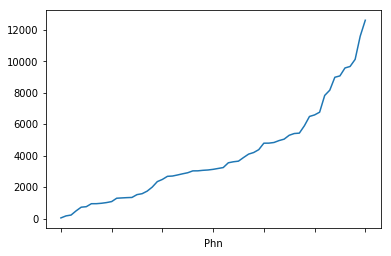

In [24]:
src.groupby(['Phn'])['Source'].count().sort_values().plot();

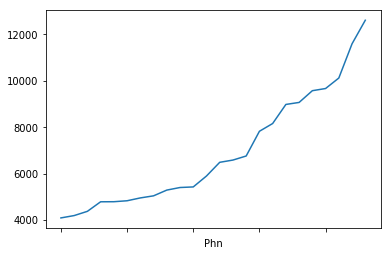

In [25]:
# Try to keep the phonemes with a minimum frequency to see if model improves
# TODO: 
# - Understand why some phonemes have so low frequency
# - Instead of removing low frequency samples, label them with "<UNK>"
MIN_FREQUENCY = 4000
idx = src.groupby(['Phn'])['Source'].count()
idx = idx[idx>MIN_FREQUENCY]
src2 = src[src.Phn.isin(idx.index)]
src2.groupby(['Phn'])['Source'].count().sort_values().plot();

In [26]:
# Save
src = src2

In [29]:
# Normal datablock setup from our AudioList from above.
data = (AudioList.from_df(src, path='.', cols=['Sample'])
    .split_by_rand_pct(0.2)
    .label_from_df('Phn')
    .transform([[pad_to_max], [pad_to_max]])
    .databunch(bs=64))        

In [31]:
data.get(20)

AudioItem Duration: 0.155 seconds.

## CNN Classifier

Adapt new input layer

In [58]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy) # , callback_fns=ShowGraph)

In [37]:
def adapt_first_layer(src_model, nChannels):
    '''
    Change first layer of network to accomodate new channels
    '''
    # save original
    original_weights = src_model[0][0].weight.clone()
    new_weights = original_weights[:,0:1,:,:]

    # create new layes
    new_layer = nn.Conv2d(nChannels,64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    new_layer.weight = nn.Parameter(new_weights)

    # Replace layer and put to gpu.
    src_model[0][0] = new_layer
    src_model.cuda();

In [61]:
nChannels=1

# Alter existing model
adapt_first_layer(learn.model,nChannels)
print(f'First layer shape: {learn.model[0][0].weight.shape}')

First layer shape: torch.Size([64, 1, 7, 7])


## Train with most frequent classes

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


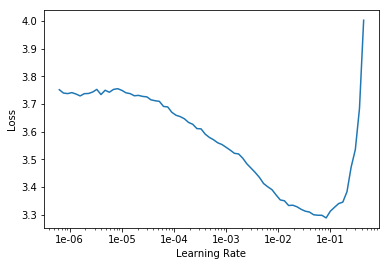

In [115]:
lr_find(learn)
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,1.627059,1.552753,0.467057,12:06
1,1.243205,1.257623,0.532312,12:08
2,1.109092,1.074307,0.624595,12:09
3,1.061449,1.116644,0.598919,12:09


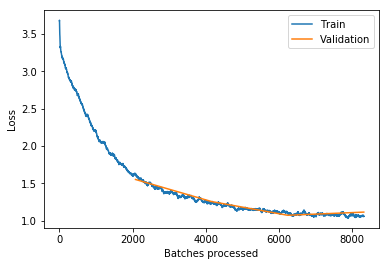

In [124]:
learn.fit_one_cycle(4, slice(2e-3))
learn.recorder.plot_losses()

In [125]:
learn.save('timit_res50_mf4000_1');

In [100]:
learn.load('timit_res50_mf4000_1');

In [101]:
learn.freeze_to(1)

epoch,train_loss,valid_loss,accuracy,time
0,1.070414,1.078240,0.611832,12:08
1,1.048522,1.031019,0.626937,12:08
2,1.018599,1.009389,0.631562,12:09
3,1.042732,1.075839,0.619279,12:08


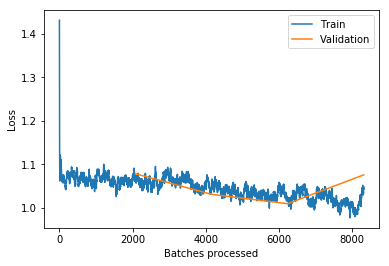

In [126]:
learn.fit_one_cycle(4, slice(2e-3/5))
learn.recorder.plot_losses()

In [127]:
learn.save('timit_res50_mf4000_2');

In [128]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


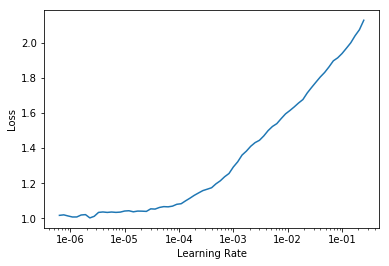

In [129]:
lr_find(learn)
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,1.033141,1.034492,0.624024,16:28
1,0.966400,1.950900,0.452763,16:29
2,0.902522,0.989884,0.653423,16:29
3,0.876313,0.865511,0.688799,16:29


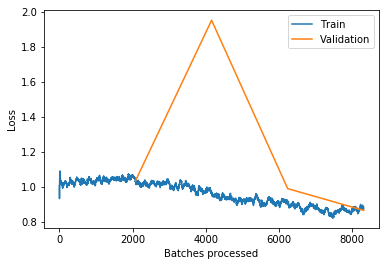

In [130]:
learn.fit_one_cycle(4, slice(1e-6,2e-4))
learn.recorder.plot_losses()

In [131]:
learn.save('timit_res50_mf4000_3');

In [133]:
print(f'Actual number of classes: {learn.data.c}')

Actual number of classes: 24


## Feed the whole dataset with all the classes
WARNING: when we reload the weights from the previous training, we should not load the last fully connected classification layer that was "made" for less classes.

In [66]:
learn.load('timit_res50_mf4000_3');

In [67]:
dataAll = (AudioList.from_df(final, path='.', cols=['Sample'])
    .split_by_rand_pct(0.2)
    .label_from_df('Phn')
    .transform([[pad_to_max], [pad_to_max]])
    .databunch(bs=64))

In [68]:
learnAll = cnn_learner(dataAll, models.resnet50, metrics=accuracy) # , callback_fns=ShowGraph)

In [69]:
nChannels=1

# Alter existing model
adapt_first_layer(learnAll.model,nChannels)
print(f'First layer shape: {learnAll.model[0][0].weight.shape}')

First layer shape: torch.Size([64, 1, 7, 7])


In [70]:
learn.model[1][8]

Linear(in_features=512, out_features=24, bias=True)

In [71]:
learnAll.model[1][8]

Linear(in_features=512, out_features=61, bias=True)

The difference between the first and second model is **only** the output of the last layer (24 vs 61 out_features), so we need to replace that layer only with a new one.

In [72]:
def adapt_last_layer(src_model, nFeatures):
    '''
    Change last layer of network to accomodate new number of features
    '''
    # save original
    #original_weights = src_model[1][8].weight.clone()
    #new_weights = original_weights[:,0:1,:,:]

    # create new layes
    new_layer = nn.Linear(in_features=512, out_features=nFeatures, bias=True)
#    new_layer.init # remember to initialize it

    # Replace layer and put to gpu.
    src_model[1][8] = new_layer
    src_model.cuda();

In [73]:
adapt_last_layer(learn.model, 61)
learn.model[1][8]

Linear(in_features=512, out_features=61, bias=True)

In [74]:
# substitute
learn.data = dataAll

In [75]:
print(f'Actual number of classes: {learn.data.c}')

Actual number of classes: 61


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


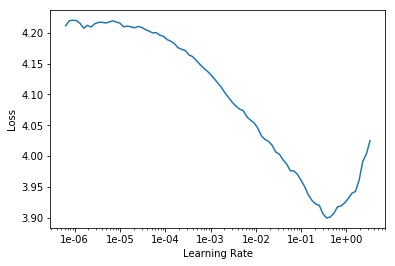

In [55]:
lr_find(learn)
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,1.625701,1.641424,0.507472,17:39
1,1.496621,2.400981,0.548762,17:35
2,1.400046,2.076496,0.541341,17:36
3,1.363223,1.819532,0.587294,17:36


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



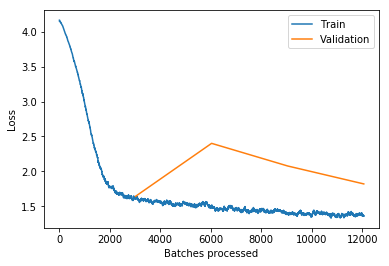

In [76]:
learn.fit_one_cycle(4, slice(2e-3))
learn.recorder.plot_losses()

In [78]:
learn.save('timit_res50_all_1');

In [79]:
learn.freeze_to(1)

In [ ]:
learn.fit_one_cycle(4, slice(2e-3/5))
learn.recorder.plot_losses()

epoch,train_loss,valid_loss,accuracy,time


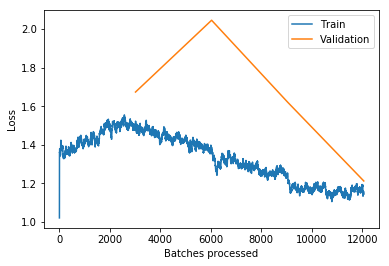

In [81]:
learn.recorder.plot_losses()

In [87]:
learn.recorder.metrics

[[tensor(0.5115)], [tensor(0.4192)], [tensor(0.5197)], [tensor(0.6236)]]

In [88]:
learn.save('timit_res50_all_2');

In [90]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


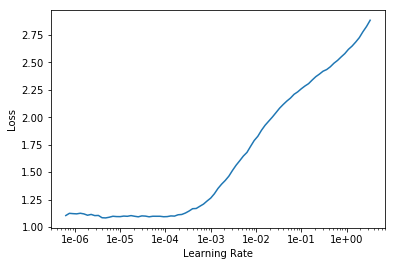

In [91]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(4, slice(1e-6,2e-4))
learn.recorder.plot_losses()

epoch,train_loss,valid_loss,accuracy,time
